# Introduction

***
This notebook is a big homework for the OSDA course. \
Made by Kolotov Anton, мИИАД22 group.
***

The notebook is organized as follows:
- Data part:
    - Dataset and quality metric description
    - Binarization strategy
    - Splitting data
- FCA part:
    - Selection of formal concepts
    - Vizualization of ConceptNetwork structure
- Neural Network part
    - NN optimization
    - ConceptNetwork model quality
- Some experiments:
    - Comparison of different binarization strategies
    - Comparison of different activation functions (nonlinearities)
    - Hyperparameters tuning
- Combining all - best model:
    - Quality measurements
    - Model vizualization
- Best model vs SotA approaches
- Conclusion

# Import

In [1]:
# for data analysis
import numpy as np
import pandas as pd
# for neural network
import torch.nn as nn
import torch.nn.functional as F
import neural_lib as nl
# for fca
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
# for vizualization
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt
import networkx as nx

plt.rcParams['figure.facecolor'] = (1,1,1,1)
# pipeline
import nfca_pipeline as pipe

# Dataset

## Dataset description

Let me introduce the dataset "Credit Card Approvals" - small dataset for binary classification task. Dataset is openly available:
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Credit+Approval?msclkid=200008bdc4a311ec9f500a3245a2bfb1) - original dataset
- [kaggle](https://www.kaggle.com/datasets/samuelcortinhas/credit-card-approval-clean-data) - the cleared version (this one is used)

This dataset has good mix of attributes - continuous, categorical with small numbers of values, and categorical with larger numbers of values.

In [2]:
df = pipe.load_data()
df

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,0,ByBirth,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,0,ByBirth,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,0,ByBirth,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,1,ByBirth,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,0,ByOtherMeans,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,21.08,10.085,0,0,Education,Black,1.25,0,0,0,0,ByBirth,0,0
686,0,22.67,0.750,1,1,Energy,White,2.00,0,1,2,1,ByBirth,394,0
687,0,25.25,13.500,0,0,Healthcare,Latino,2.00,0,1,1,1,ByBirth,1,0
688,1,17.92,0.205,1,1,ConsumerStaples,White,0.04,0,0,0,0,ByBirth,750,0


The dataset contains 690 objects, each described by 15 attributes:
- binary: `Gender`, `Married`, `BankCustomer`, `PriorDefault`, `Employed`, `DriversLicense`
- numeric: `Age`, `Debt`, `YearsEmployed`, `Income`, `CreditScore`
- categorical: `Industry`, `Ethnicity`, `Citizen`
- target: `Approved`

In [3]:
df.nunique()

Gender              2
Age               350
Debt              215
Married             2
BankCustomer        2
Industry           14
Ethnicity           5
YearsEmployed     132
PriorDefault        2
Employed            2
CreditScore        23
DriversLicense      2
Citizen             3
Income            240
Approved            2
dtype: int64

In [4]:
df.describe()

,Gender,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Income,Approved
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000
mean,0.695652,31.514116,4.758725,0.760870,0.763768,2.223406,0.523188,0.427536,2.40000,0.457971,1017.385507,0.444928
std,0.460464,11.860245,4.978163,0.426862,0.425074,3.346513,0.499824,0.495080,4.86294,0.498592,5210.102598,0.497318
min,0.000000,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,22.670000,1.000000,1.000000,1.000000,0.165000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,1.000000,28.460000,2.750000,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,5.000000,0.000000
75%,1.000000,37.707500,7.207500,1.000000,1.000000,2.625000,1.000000,1.000000,3.00000,1.000000,395.500000,1.000000
max,1.000000,80.250000,28.000000,1.000000,1.000000,28.500000,1.000000,1.000000,67.00000,1.000000,100000.000000,1.000000


## Suitable quality metric

Firstly, note that the dataset is balanced (~44% positive objects):

In [5]:
df['Approved'].value_counts()

0    383
1    307
Name: Approved, dtype: int64

For binary classification tasks , the following metrics are commonly used:
(in terms of confusion matrix)
$$
\begin{align*}
Accuracy &= \frac{TP}{TP+TN+FP+FN} \\
Precision &= \frac{TP}{TP+FP} \\
Recall &= \frac{TP}{TP+FN} \\
F1 &= \frac{2\cdot Precision \cdot Recall}{Precision + Recall} \\
\end{align*}

Since the dataset is balanced we are free to use Accuracy metric, but in tasks such as credit scoring we usually pay more attention to the positive class, so let's use F1 metric instead.

In [6]:
from sklearn.metrics import f1_score

## Binarization strategy

Let's binarize data is such way:
- For categorical and binary features let's use one-hot encoding
- For numeric features let's select bins (using quantiles), then use interval $[b_i, b_j] \; \forall b_i, b_j \in bins$
- Binary features let's keep the same

In [7]:
cat_features = ['Industry', 'Ethnicity', 'Citizen']
num_features = ['Age', 'Debt', 'YearsEmployed', 'Income', 'CreditScore']

X = df.drop(['Approved'], axis=1)
y = df['Approved'].astype(bool)

In [8]:
X_bin = pipe.binarize_X(X, cat_features=cat_features, num_features=num_features, q_num=5)
X_bin.shape

(690, 49)

Now we have 49 binary attributes :)

## Splitting data

Let's split the dataset to train (40%), validation(20%) and test (40%) groups of data. We will use train data for computing formal concepts and fitting network. Validation data - for tuning parameters (such as the number of concepts) and test data - for quality measurment. 

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = pipe.split_data(X_bin, y, test_size=0.4, val_size=0.2)

In [10]:
X_train.shape, X_val.shape, X_test.shape

((275, 49), (139, 49), (276, 49))

# FCA

## Find best formal concepts

Use train data to compute monotone ConceptLattice. Since `CbO` algorithm is too slow, let;s use `Sofia` algo instead to select only few interesting concepts. Then, compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [11]:
K, L = pipe.evaluate_concepts(X_train, y_train, algo='Sofia', criterion=('f1_score', f1_score))

Text(0.5, 1.0, 'F1 score for all concepts')

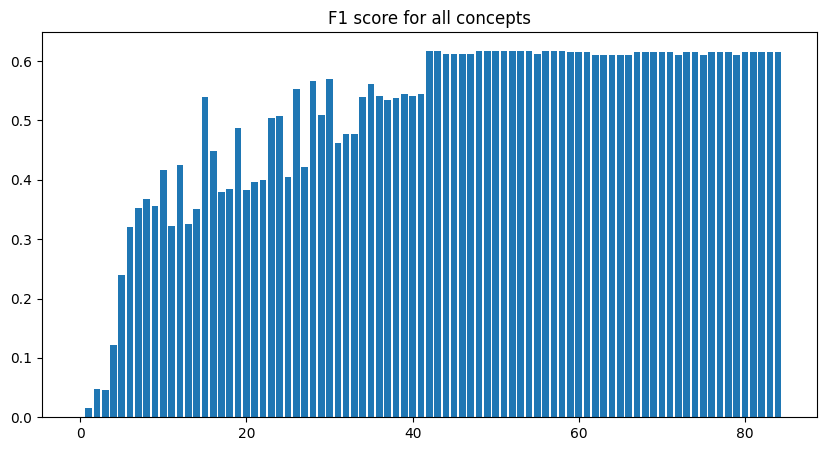

In [12]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

sorted_i = L.measures['f1_score'].argsort()[::-1]
ax.bar(sorted_i, L.measures['f1_score'][sorted_i])
ax.set_title('F1 score for all concepts')

The concepts at the lasts levels have the maximum F1 score. Let's choose 15 best concepts (we have to cover all train objects).

In [13]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:15])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K.n_objects, "Selected concepts do not cover all train objects"

In [14]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

## Vizualization of the ConceptNetwork structure

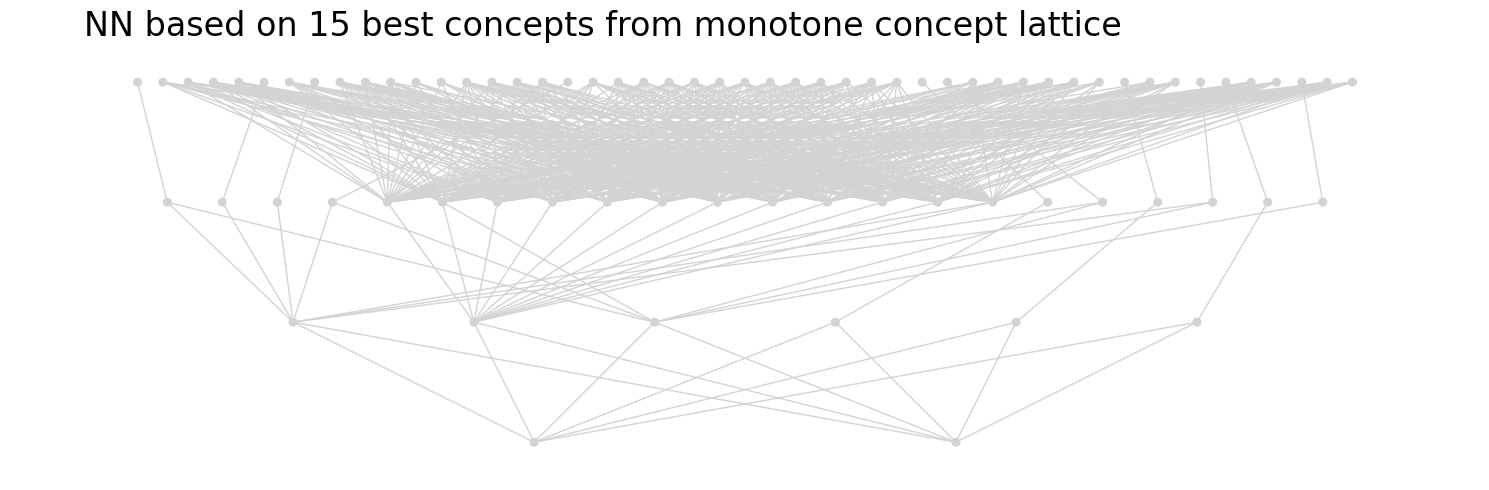

In [15]:
fig, ax = plt.subplots(figsize=(15,5))

vis = LineVizNx(node_size=30, node_border_color='black', node_border_width=1000)
vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_color='lightgray'
)
plt.title(f'NN based on 15 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

# Neural Network

Note, the `neural_lib` file has been modified in such way:
- Add history for `fit` function
- Add eval dataset to `fit` fucntion (to control overfitting)
- Drop `Sigmoid` activation function on the last layer - it's already implemented in loss function - `CrossEntropyLoss`
- Prettify `fit` and `predict` functions with `model.train()/eval()` modes and `torch.no_grad()` context manager

## Optimization

Let's fit our NN and see what happened. We use optimizer Adam with a huge number of epochs $ = 2000$ and learning rate $ = 0.001$. As nonlinearity we use `ReLU` as default.

In [36]:
hist = cn.fit(X_train, y_train, X_val, y_val, f1_score, nonlinearity=nn.ReLU)

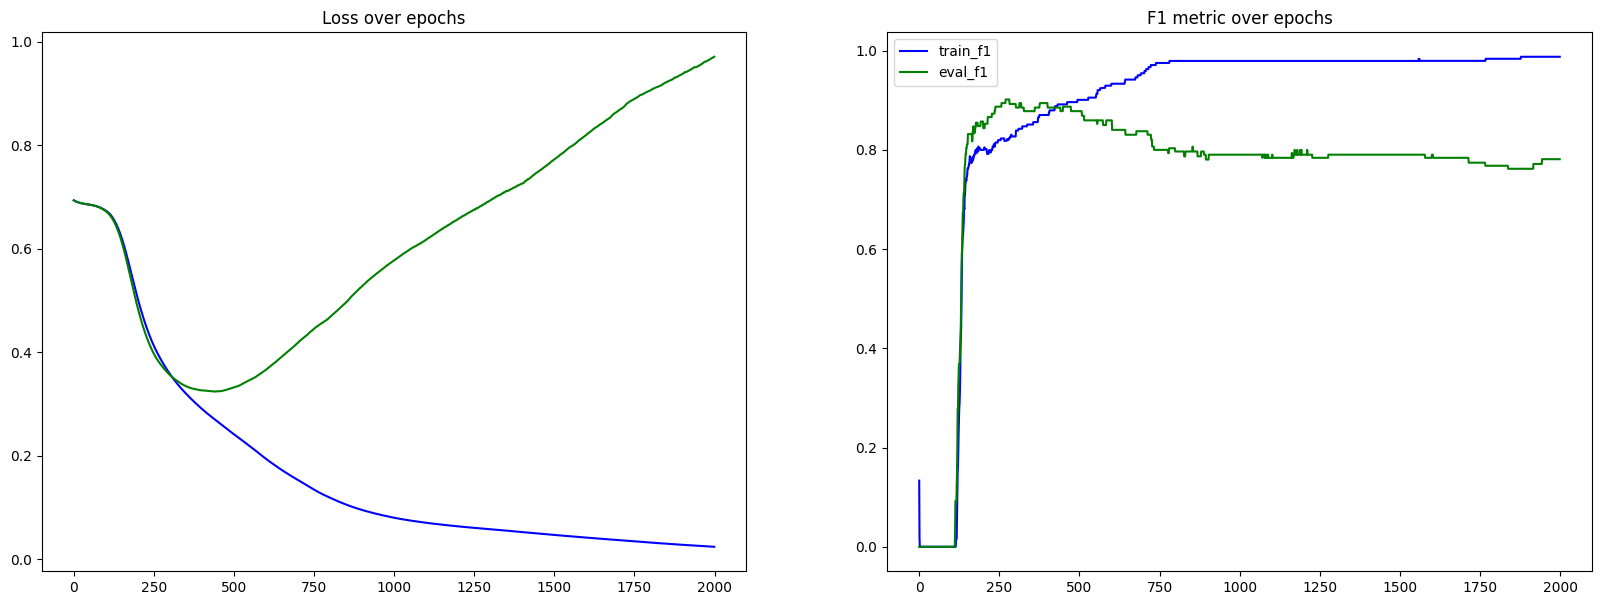

In [37]:
fig = plt.figure(figsize=(20,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


ax1.plot(hist['train']['loss'], color='b', label='train_loss')
ax1.plot(hist['eval']['loss'], color='g', label='eval_loss')
ax1.set_title('Loss over epochs')


ax2.plot(hist['train']['metric'], color='b', label='train_f1')
ax2.plot(hist['eval']['metric'], color='g', label='eval_f1')
ax2.set_title('F1 metric over epochs')

plt.legend()

As we can see - the max quality is acheved with a small (250) number of epochs, then the network begins to overfitting. Let's fix the number of epochs on 250 and measure quality on dataset.

In [38]:
_ = cn.fit(X_train, y_train, X_val, y_val, f1_score, nonlinearity=nn.ReLU, n_epochs=250)

In [39]:
y_pred = cn.predict(X_test)
y_pred_val = cn.predict(X_val)
y_pred_train = cn.predict(X_train)

print("Test Quality : ", f1_score(y_test, y_pred))
print("Val Quality : ", f1_score(y_val, y_pred_val))
print("Train Quality : ", f1_score(y_train, y_pred_train))

Test Quality :  0.8050847457627119
Val Quality :  0.823529411764706
Train Quality :  0.8305084745762712


We have achieved $0.80$ F1 score on test dataset - it's good but let's start experiments to improve it!

# Experiments

## Comparison of different binarization strategies

Firstly, let's improve our binarization strategy. Studying lattices, i noticed that associative rules do not support negation natively: for example, if there is a attribute "yellow", then we cannot get a rule: if not "yellow" then .... So, after getting the binary context, let's add a negation for each attribute.

In [40]:
X_bin = pipe.binarize_X(X, cat_features=cat_features, num_features=num_features, q_num=5, add_negation=True)
X_train, X_val, X_test, y_train, y_val, y_test = pipe.split_data(X_bin, y, test_size=0.4, val_size=0.2)
K, L = pipe.evaluate_concepts(X_train, y_train, algo='Sofia', criterion=('f1_score', f1_score))
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:15]) # let's choose 15 best concepts
assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K.n_objects, "Selected concepts do not cover all train objects"
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
hist = cn.fit(X_train, y_train, X_val, y_val, f1_score, nonlinearity=nn.ReLU, n_epochs=250) # 250 epochs

As we can see below, the F1 score increased to $0.827$ on test dataset!

In [41]:
y_pred = cn.predict(X_test)
y_pred_val = cn.predict(X_val)
y_pred_train = cn.predict(X_train)

print("Test Quality : ", f1_score(y_test, y_pred))
print("Val Quality : ", f1_score(y_val, y_pred_val))
print("Train Quality : ", f1_score(y_train, y_pred_train))

Test Quality :  0.8278688524590164
Val Quality :  0.8429752066115702
Train Quality :  0.8389830508474576


Also, for numeric features let's compare 2 strategies: select bins (using quantiles), then:
- `range` - use interval $[b_i, b_j] \; \forall b_i, b_j \in bins$
- `semirange` - use interval $[-\infty, b_i] \; \forall b_i \in bins$

For `range`, we have calculations above, for `semirange` calculations are shown below:

In [42]:
X_bin = pipe.binarize_X(X, cat_features=cat_features, num_features=num_features, q_num=5, add_negation=True, num_strategy='semirange')
X_train, X_val, X_test, y_train, y_val, y_test = pipe.split_data(X_bin, y, test_size=0.4, val_size=0.2)
K, L = pipe.evaluate_concepts(X_train, y_train, algo='Sofia', criterion=('f1_score', f1_score))
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:15]) # let's choose 15 best concepts
assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K.n_objects, "Selected concepts do not cover all train objects"
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
hist = cn.fit(X_train, y_train, X_val, y_val, f1_score, nonlinearity=nn.ReLU, n_epochs=250) # 250 epochs

In [43]:
y_pred = cn.predict(X_test)
y_pred_val = cn.predict(X_val)
y_pred_train = cn.predict(X_train)

print("Test Quality : ", f1_score(y_test, y_pred))
print("Val Quality : ", f1_score(y_val, y_pred_val))
print("Train Quality : ", f1_score(y_train, y_pred_train))

Test Quality :  0.8050847457627119
Val Quality :  0.8135593220338982
Train Quality :  0.829059829059829


The quality has decreased, so the best binarization is defined as follows:
- For categorical and binary features let's use one-hot encoding
- For numeric features let's compare (see experiments) 2 strategies: select bins (using quantiles), then use interval $[b_i, b_j] \; \forall b_i, b_j \in bins$
- Binary features let's keep the same
- After such binarization for all features let's use both it and its negation

Let's use this binarization further.

In [44]:
X_bin = pipe.binarize_X(X, cat_features=cat_features, num_features=num_features, q_num=5, add_negation=True, num_strategy='range')
X_train, X_val, X_test, y_train, y_val, y_test = pipe.split_data(X_bin, y, test_size=0.4, val_size=0.2)
K, L = pipe.evaluate_concepts(X_train, y_train, algo='Sofia', criterion=('f1_score', f1_score))

## Choosing the right number of concepts

Let's try to find the best number of concepts - using validation dataset and concidering number of concepts as hyperparameter.

In [46]:
grid = list(range(2, len(L)))
scores = []

In [49]:
for k in grid:
    best_concepts = list(L.measures['f1_score'].argsort()[::-1][:k])
    if len({g_i for c in L[best_concepts] for g_i in c.extent_i})!=K.n_objects:
        scores.append(0)
        continue
    cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
    tmp_score = 0
    for _ in range(5):
        cn.fit(X_train, y_train, X_val, y_val, f1_score, nonlinearity=nn.ReLU, n_epochs=250)
        tmp_score += f1_score(y_val, cn.predict(X_val)) / 5
    scores.append(tmp_score)

Text(0.5, 1.0, 'F1 over number of concepts')

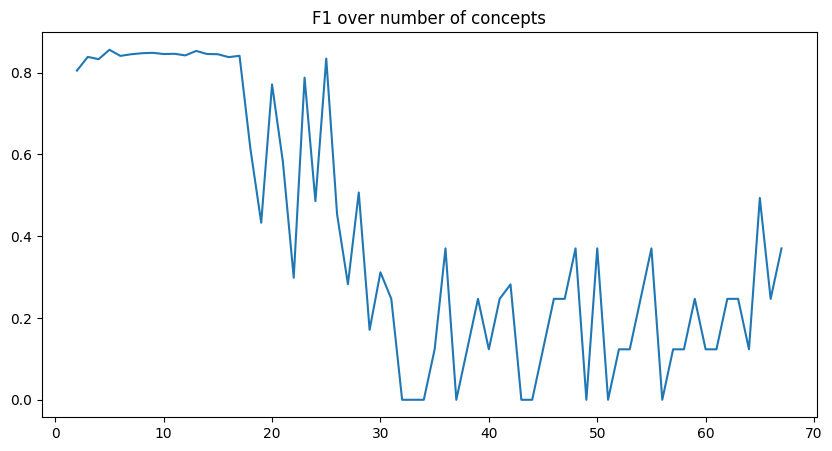

In [50]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.plot(grid, scores)
ax.set_title('F1 over number of concepts')

In [51]:
best_k = grid[np.argmax(scores)]
best_k

5

So, the number of concepts that shows the best quality is $5$. Let's use it further.

In [54]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:best_k])
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

## Comparison of different activation functions (nonlinearities)

Then, let's experiment with the model so that it doesn't overfitting. Let's decrease learning rate to `3e-4` - magic value for training any network. Then, fix the number of epoch at acceptable level (750). Then, try to use the following activation functions:
- `ReLU`
- `Sigmoid`
- `LeakyReLU` with $\alpha = 0.01$
- `Tanh`

In [99]:
lr = 3e-4
n_epochs = 2000

In [100]:
quality = {}
hist_relu = cn.fit(X_train, y_train, X_val, y_val, f1_score, nonlinearity=nn.ReLU, n_epochs=n_epochs, lr=lr)
quality['relu'] = {
    'train': f1_score(y_train, cn.predict(X_train)),
    'val': f1_score(y_val, cn.predict(X_val)),
    'test': f1_score(y_test, cn.predict(X_test)),
}
hist_sigmoid = cn.fit(X_train, y_train, X_val, y_val, f1_score, nonlinearity=nn.Sigmoid, n_epochs=n_epochs, lr=lr)
quality['sigmoid'] = {
    'train': f1_score(y_train, cn.predict(X_train)),
    'val': f1_score(y_val, cn.predict(X_val)),
    'test': f1_score(y_test, cn.predict(X_test)),
}
hist_leaky = cn.fit(X_train, y_train, X_val, y_val, f1_score, nonlinearity=nn.LeakyReLU, n_epochs=n_epochs, lr=lr)
quality['leakyrelu'] = {
    'train': f1_score(y_train, cn.predict(X_train)),
    'val': f1_score(y_val, cn.predict(X_val)),
    'test': f1_score(y_test, cn.predict(X_test)),
}
hist_tanh = cn.fit(X_train, y_train, X_val, y_val, f1_score, nonlinearity=nn.Tanh, n_epochs=n_epochs, lr=lr)
quality['tanh'] = {
    'train': f1_score(y_train, cn.predict(X_train)),
    'val': f1_score(y_val, cn.predict(X_val)),
    'test': f1_score(y_test, cn.predict(X_test)),
}

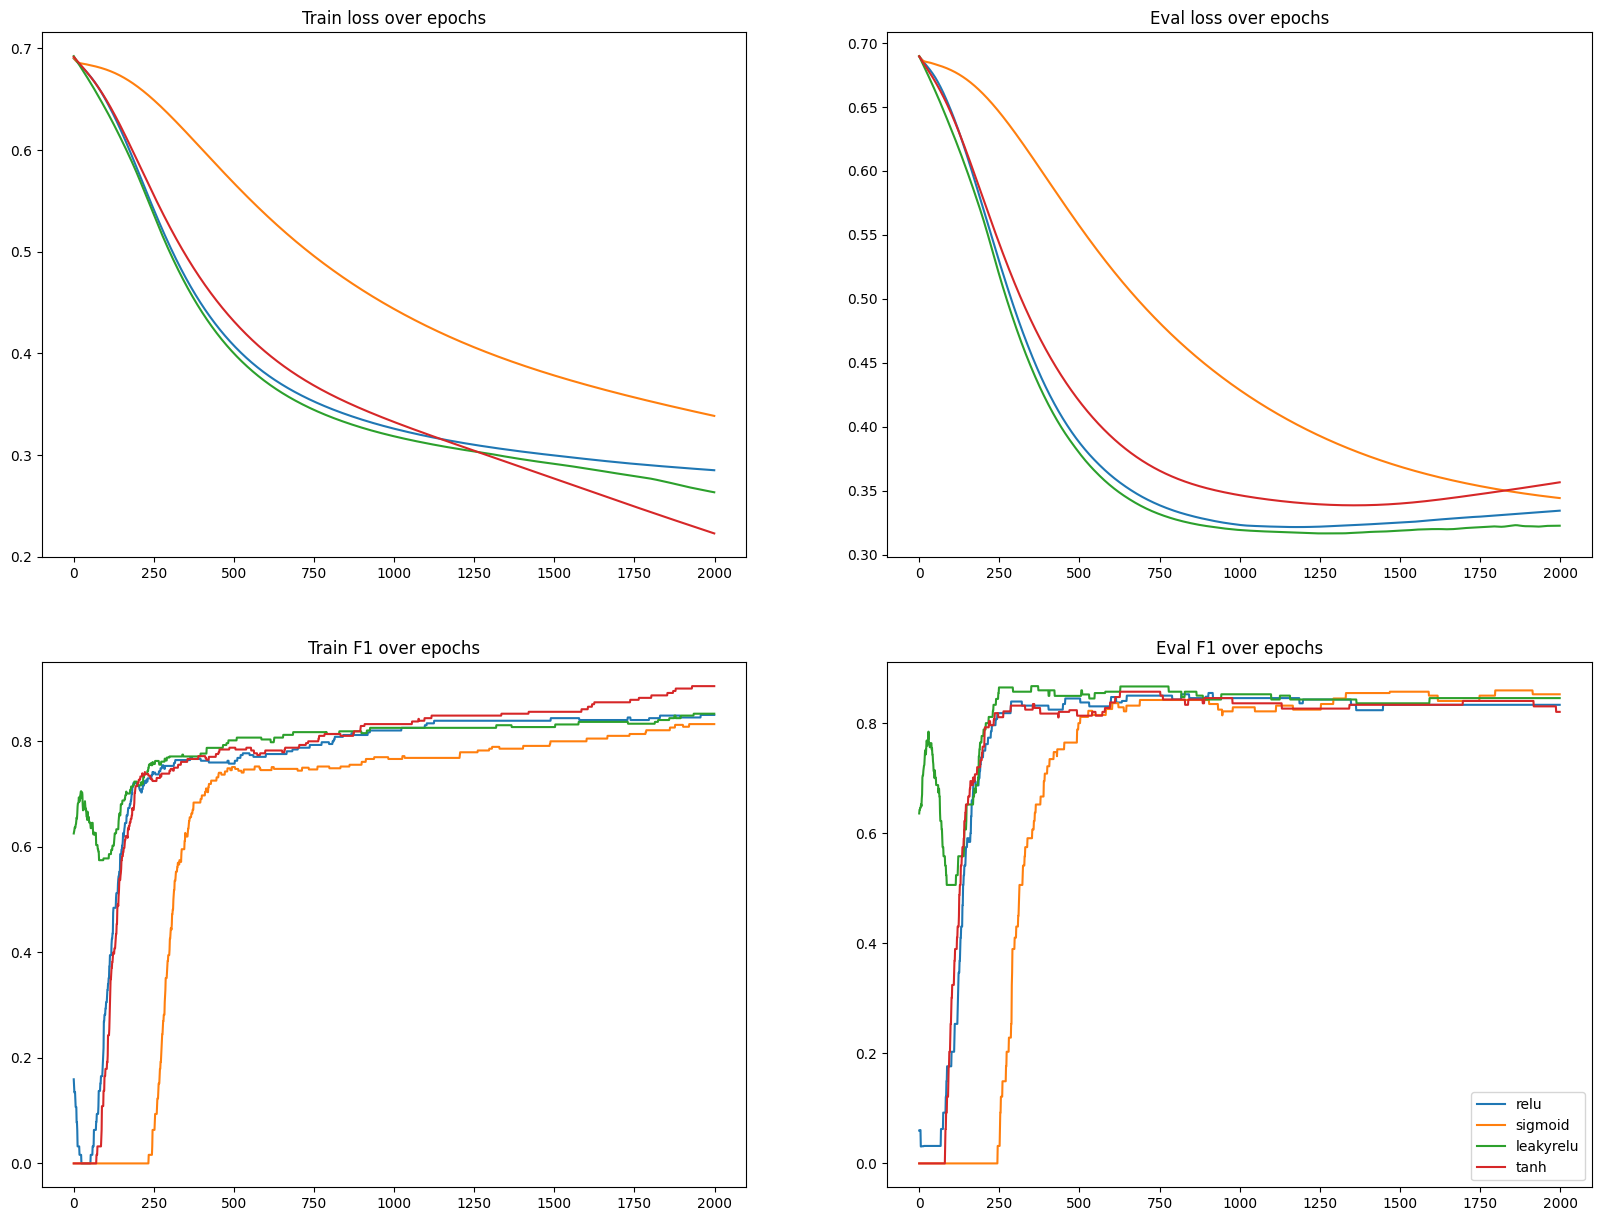

In [101]:
hists = [hist_relu, hist_sigmoid, hist_leaky, hist_tanh]
labels = ['relu', 'sigmoid', 'leakyrelu', 'tanh']

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

for h, label in zip(hists, labels):

    ax1.plot(h['train']['loss'], label=label)
    ax2.plot(h['eval']['loss'], label=label)
    ax3.plot(h['train']['metric'], label=label)
    ax4.plot(h['eval']['metric'], label=label)

ax1.set_title('Train loss over epochs')
ax2.set_title('Eval loss over epochs')
ax3.set_title('Train F1 over epochs')
ax4.set_title('Eval F1 over epochs')
plt.legend()

In [102]:
quality_df = pd.DataFrame.from_dict(quality).T
quality_df

,train,val,test
relu,0.850000,0.833333,0.827869
sigmoid,0.832618,0.852459,0.811715
leakyrelu,0.852321,0.845528,0.832653
tanh,0.904564,0.820513,0.809917


So, we can see that the `LeakyReLU` shows the best quality - $0.83$

# Сombining all best approaches

So, after all experiments we can combine all best into model:

In [ ]:
X_bin = pipe.binarize_X(X, cat_features=cat_features, num_features=num_features, q_num=5, add_negation=True, num_strategy='range')
X_train, X_val, X_test, y_train, y_val, y_test = pipe.split_data(X_bin, y, test_size=0.4, val_size=0.2)
K, L = pipe.evaluate_concepts(X_train, y_train, algo='Sofia', criterion=('f1_score', f1_score))

best_concepts = list(L.measures['f1_score'].argsort()[::-1][:best_k])
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

_ = cn.fit(X_train, y_train, X_val, y_val, f1_score, nonlinearity=nn.LeakyReLU, n_epochs=n_epochs, lr=lr)

## Vizualization of the best ConceptNetwork

How beautiful it looks...

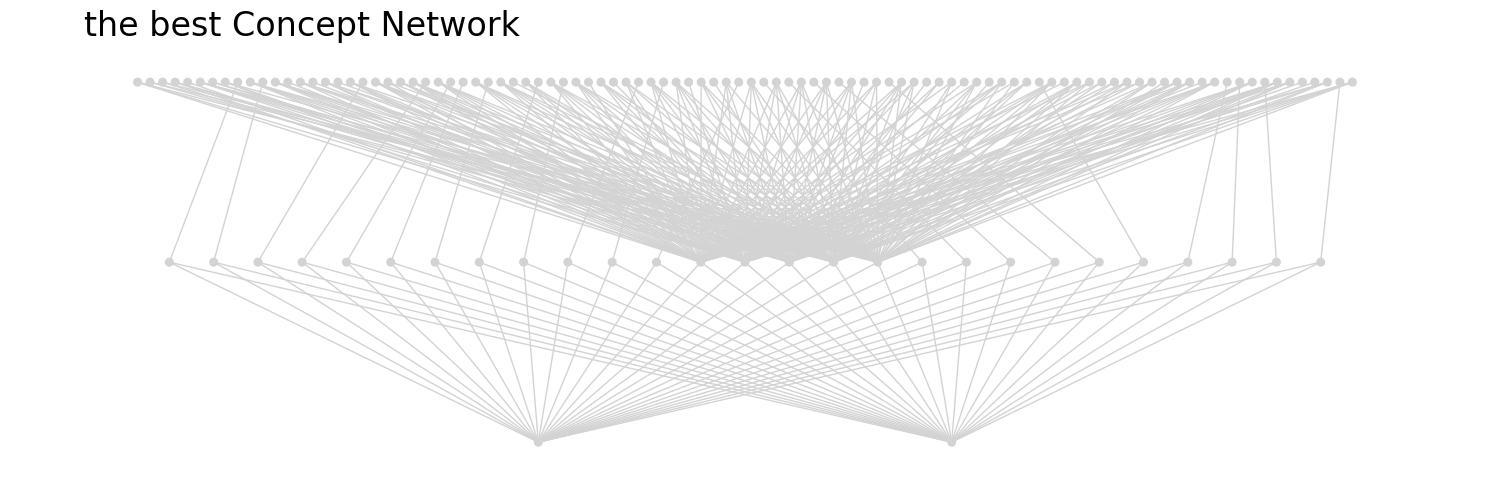

In [104]:
fig, ax = plt.subplots(figsize=(15,5))

vis = LineVizNx(node_size=30, node_border_color='black', node_border_width=1000)
vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_color='lightgray'
)
plt.title(f'the best Concept Network', loc='left', x=0.05, size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

# The best ConceptNetwork model vs State-of-the-Art approaches

As SotA approaches we will try:
- Decision Tree
- Random Forest
- Boosting - Catboost (since we have categorical features)
- LogReg - linear model
- KNN - k-nearest neighbor algorithm
- MLP - fully-connected neural network with same number of neurons

We will use not binarized dataset for Catboost, with only categorical features binarized for others and full binarized one for ContextNetwork.

In [109]:
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

In [53]:
def make_predictions(model, Xs, ys, names, metric=f1_score):
    q = {}
    for X, y, name in zip(Xs, ys, names):
        q[name] = metric(y, model.predict(X))
    return q

In [111]:
X_train, X_val, X_test, y_train, y_val, y_test = pipe.split_data(X, y, test_size=0.4, val_size=0.2)
X_train_cat, X_val_cat, X_test_cat, y_train, y_val, y_test = pipe.split_data(pd.get_dummies(X), y, test_size=0.4, val_size=0.2)
X_train_bin, X_val_bin, X_test_bin, y_train, y_val, y_test = pipe.split_data(X_bin, y, test_size=0.4, val_size=0.2)

In [112]:
scaler = StandardScaler()
X_train_cat = scaler.fit_transform(X_train_cat)
X_val_cat = scaler.transform(X_val_cat)
X_test_cat = scaler.transform(X_test_cat)

In [133]:
dt = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=4)
boost = CatBoostClassifier(use_best_model=True, silent=True,eval_metric='F1',random_state=42)
rf = RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=28,random_state=42)
logreg = LogisticRegression(random_state=42)
mlp = MLPClassifier((27,),random_state=42, max_iter=2000)
knn = KNeighborsClassifier(n_neighbors=19)

In [134]:
dt.fit(X_train_cat, y_train)
boost.fit(X_train, y_train.astype(int), eval_set=(X_val, y_val.astype(int)), cat_features=cat_features)
rf.fit(X_train_cat, y_train)
logreg.fit(X_train_cat, y_train)
knn.fit(X_train_cat, y_train)
mlp.fit(X_train_cat, y_train)
_ = _

In [135]:
quality = {}
quality['DT'] = make_predictions(dt, [X_train_cat, X_val_cat, X_test_cat], [y_train, y_val, y_test], ['train', 'val', 'test'])
quality['Catboost'] = make_predictions(boost, [X_train, X_val, X_test], [y_train.astype(int), y_val.astype(int), y_test.astype(int)], ['train', 'val', 'test'])
quality['RF'] = make_predictions(rf, [X_train_cat, X_val_cat, X_test_cat], [y_train, y_val, y_test], ['train', 'val', 'test'])
quality['LogReg'] = make_predictions(logreg, [X_train_cat, X_val_cat, X_test_cat], [y_train, y_val, y_test], ['train', 'val', 'test'])
quality['KNN'] = make_predictions(knn, [X_train_cat, X_val_cat, X_test_cat], [y_train, y_val, y_test], ['train', 'val', 'test'])
quality['MLP'] = make_predictions(mlp, [X_train_cat, X_val_cat, X_test_cat], [y_train, y_val, y_test], ['train', 'val', 'test'])
quality['ContextNetwork'] = make_predictions(cn, [X_train_bin, X_val_bin, X_test_bin], [y_train, y_val, y_test], ['train', 'val', 'test'])

In [136]:
quality_df = pd.DataFrame.from_dict(quality).T
quality_df

,train,val,test
DT,0.870690,0.834783,0.808333
Catboost,0.841667,0.934426,0.868526
RF,0.975207,0.847458,0.831933
LogReg,0.834711,0.857143,0.789916
KNN,0.746667,0.789474,0.771930
MLP,0.991803,0.764228,0.762295
ContextNetwork,0.851240,0.845528,0.832653


As we can see, the ContextNetwork achieves results comparable to SotA - it is on the same level with Decision Tree and Random Forest and only Catboost outperforms it.